In [1]:
from scipy.special import expit
from rbmpy.rbm import RBM
from rbmpy.sampler import DirtyCorrectionMulDimSampler,VanillaSampler,ContinuousSampler,ContinuousApproxSampler, ContinuousApproxMulDimSampler, ApproximatedSampler, LayerWiseApproxSampler,ApproximatedMulDimSampler
from rbmpy.trainer import VanillaTrainier
from rbmpy.performance import Result
import numpy as np
import rbmpy.datasets, rbmpy.performance, rbmpy.plotter, pickle, rbmpy.rbm, os, logging, rbmpy.sampler,math
import math
from rbmpy.rbm import weights_into_hiddens
from rbmpy.progress import Progress
from scipy.spatial.distance import cosine


import rbmpy.plotter as pp
from numpy import newaxis
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

logger = logging.getLogger()
# Set the logging level to logging.DEBUG 
logger.setLevel(logging.INFO)

%matplotlib inline

In [2]:
with open("mnist_data", 'rb') as f:
    full_mnist_data = pickle.load(f)

In [3]:
# load RBMs trained on 2s and 3s

In [4]:
two_rbm, two_ds = full_mnist_data[2]
three_rbm, three_ds = full_mnist_data[3]

In [5]:
def print_weight_info(rbm):
    print("min  {}".format(rbm.weights.min()))
    print("max  {}".format(rbm.weights.max()))
    print("mean {}".format(rbm.weights.mean()))
    print("std  {}".format(rbm.weights.std()))

In [6]:
print_weight_info(two_rbm)
print_weight_info(three_rbm)

min  -7.086554061133978
max  4.129461787946666
mean -0.419801847192457
std  0.916423420203806
min  -6.465314094074916
max  3.9852672863379834
mean -0.4229784834602937
std  0.9214791081351881


In [7]:
# make a sampler so we can make some dreams from the two and three RBMs
two_sampler = ContinuousSampler(two_rbm)
three_sampler = ContinuousSampler(three_rbm)
two_dream = two_sampler.dream(two_rbm, num_gibbs=1)
three_dream = three_sampler.dream(three_rbm, num_gibbs=100)
# so we get a dream visible, but we want $\phi$ so we can add and smush through sigmoid. so up and down once more
 
two_dream_h = two_sampler.visible_to_hidden(two_dream)
two_dream_phi = np.dot(two_dream_h, two_rbm.weights)

three_dream_h = three_sampler.visible_to_hidden(three_dream)
three_dream_phi = np.dot(three_dream_h, three_rbm.weights)

# sum the phi, then expit
composite_dream = expit(two_dream_phi + three_dream_phi)

In [8]:
cheating = True
if cheating:
    composite_dream = (two_ds[0] + three_ds[0]) / 2.0
    composite_dream = composite_dream.reshape(784)

#Lets take a quick look at the images if instead of combining they had just done their own thing

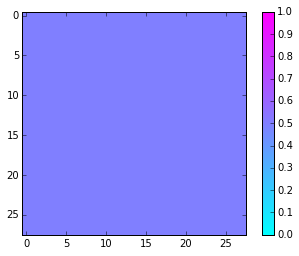

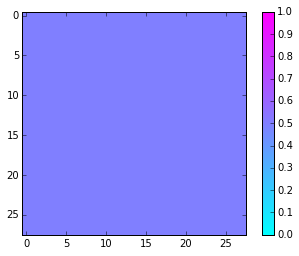

In [9]:
pp.image(expit(two_dream_phi).reshape(28,28), color_range=(0,1))
pp.image(expit(three_dream_phi).reshape(28,28), color_range=(0,1))

#And now the composition from the generative model


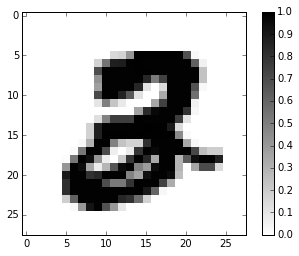

In [16]:
pp.image(np.maximum(two_ds[0], three_ds[0]), cmap=plt.cm.gray_r)

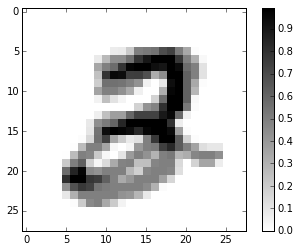

In [17]:
pp.image(composite_dream.reshape(28,28), cmap=plt.cm.gray_r)

#Now we need to compare the ORBM and RBM at reconstructing

In [53]:
help(orbm_sampler.v_to_v)

Help on method v_to_v in module rbmpy.sampler:

v_to_v(h_a, h_b, v, num_gibbs=100, logging_freq=None) method of rbmpy.sampler.ContinuousApproxSampler instance



In [54]:
# prepare the ORBM sampler
# UGh! passing a starting hidden pattern should be optional! 
rand_h_a = np.random.randint(0,2,size=( two_rbm.num_hid())) 
rand_h_b = np.random.randint(0,2,size=( three_rbm.num_hid()))

orbm_sampler = ContinuousApproxSampler(two_rbm.weights, three_rbm.weights, two_rbm.hidden_bias, three_rbm.hidden_bias)
orbm_two_recon, orbm_three_recon = orbm_sampler.v_to_v(rand_h_a,rand_h_b, composite_dream, num_gibbs=100)

# we can reuse the continous vanilla samplers from before
rbm_two_recon = two_sampler.reconstruction_given_visible(composite_dream)
rbm_three_recon = three_sampler.reconstruction_given_visible(composite_dream)

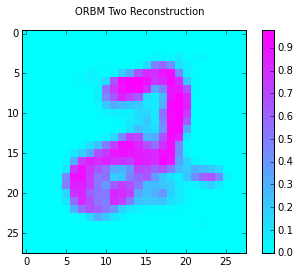

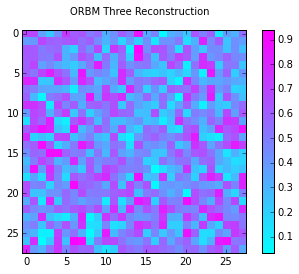

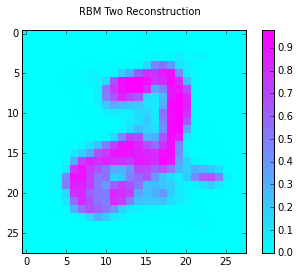

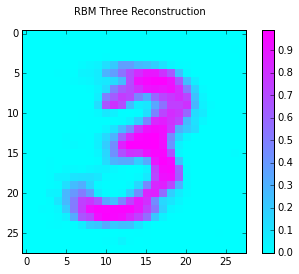

In [55]:
plt.suptitle("ORBM Two Reconstruction")
pp.image(orbm_two_recon.reshape(28,28))
plt.suptitle("ORBM Three Reconstruction")
pp.image(orbm_three_recon.reshape(28,28))

plt.suptitle("RBM Two Reconstruction")
pp.image(rbm_two_recon.reshape(28,28))
plt.suptitle("RBM Three Reconstruction")
pp.image(rbm_three_recon.reshape(28,28))